## FaceForensics++: Learning to Detect Manipulated Facial Images

<p>
The rapid progress in synthetic image generation and manipulation has now come to a  point where it raises significant concerns on the implication on the society. At best, this  leads to a loss of trust in digital content, but it might even cause further harm by  spreading false information and the creation of fake news. </p>
 <p>
In this case study, we will build a machine learning model that learns to detect  manipulated facial images.  We have access to a dataset of fake and real videos. We have to train a model to predict  whether the given video(or image sequence) is fake or real.</p> 
<p>
For more details, kindly go through <a>https://www.groundai.com/project/faceforensics-learning-to-detect-manipulated-fa cial-images/1</a> </p>


## The Dataset

1. We will download the dataset from the FaceForensics. The details of the same is well explained here <a>https://github.com/ondyari/FaceForensics</a>
2. For our dataset, we chose two computer graphics-based approaches  (​Face2Face ​ and ​FaceSwap ​ ) 
and a deep-learning-based approach  (​Deepfakes ​ ). These will give us manipulated videos.  
3. We will also download the original youtube videos from there. We will use the following script to download all images or videos.  
         download-FaceForensics.py  
4. We will have to extract the sequence images from these videos. We will  use the following script provided by FaceForensics for extracting the  frames.  
         python extracted_compressed_videos.py <output path> -d <"all" or single dataset via "Face2Face" or "original"> -c c0 

### Data collection for our model
<pre>
1. We will download 50 fake videos of each type.
    python faceforensics_download_v4.py data\fake -d Deepfakes -c c23 -t videos -n 50
    python faceforensics_download_v4.py data\fake -d Face2Face -c c23 -t videos -n 50
    python faceforensics_download_v4.py data\fake -d FaceSwap -c c23 -t videos -n 50

2. We will download 151 original videos.    
    python faceforensics_download_v4.py data\original -d youtube -c c23 -t videos -n 151
 
3. We will extract the image sequence from these videos using the following commands.
    python extracted_compressed_videos.py --data_path data\fake -d Deepfakes -c c23
    python extracted_compressed_videos.py --data_path data\fake -d Face2Face -c c23
    python extracted_compressed_videos.py --data_path data\fake -d FaceSwap -c c23
    python extracted_compressed_videos.py --data_path data\original -d original -c c23

4. We will go through these image sequences and collect 50 image sequence for EACH video and put all these in the folder       "data_set". These images will be further processed and split into train, cv and test data.
</pre>

In [52]:
import os
import pandas as pd
import numpy as np
from shutil import copyfile
import matplotlib.pyplot as plt 
import os  
from tqdm import tqdm_notebook as tqdm  
import numpy as np 
import cv2  
import dlib  
from keras.utils import to_categorical
from keras.applications.xception import preprocess_input  
import joblib
import tensorflow as tf
from tensorflow.keras.applications.xception import Xception,preprocess_input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint,TensorBoard
from tensorflow.keras import Model
from tensorflow.keras.layers import Dropout,InputLayer,Flatten,Dense,BatchNormalization,MaxPooling2D,Conv2D,Input,Concatenate,LeakyReLU 
from tensorflow.keras.callbacks import ModelCheckpoint
import warnings#
warnings.filterwarnings('ignore') 

# instantiating face detector class from dlib library 
face_detector = dlib.get_frontal_face_detector()

## Data collection: 
### Copy the required image frames from the extracted images and copy them to the folder from where it will be picked for further processing.

In [53]:
labels = []
filenames_list = []

manipulated_sequences_path = "data\\fake\manipulated_sequences"
original_sequences_path = "data\original\original_sequences"
image_dir_path = "c23\images"
dest_path = "data_set"

def copy_images(sequences_path,image_dir_path,dest_path,label_value):
    """
    This expected inputs are:
    :sequences_path: manipulated and original sequence path
    :image_dir_path: the sub dir path for the image folder
    :dest_path: destination folder to copy the image frames
    :label_value: the label value for the images, value is 0 for 'fake' and 1 for 'original'
    This function will traverse the directory path where the images were extracted and will
    copy them to the destination diretory.
    """
        
    global filenames_list,labels
    
    for dir_name in os.listdir(sequences_path):        
 
        complete_image_dir_path = os.path.join(sequences_path,dir_name,image_dir_path)

        for sub_dir_name in os.listdir(complete_image_dir_path):
            complete_image_file_path = os.path.join(complete_image_dir_path,sub_dir_name)
            files_list = os.listdir(complete_image_file_path)
             
            number_of_files = len(files_list)
            
            for file_name in files_list:
                file_number = int(file_name.split(".")[0])
                mid_value = round(number_of_files/2)
                try:
                    
                    if file_number in range(mid_value-25,mid_value + 26):
                        dest_file_path = dest_path + "\\" + sub_dir_name + file_name
                         
                        copyfile(os.path.join(complete_image_file_path,file_name), dest_file_path)
                        labels.append(label_value)
                        filenames_list.append(sub_dir_name + file_name)
                except:
                    print("Not enough files")
                    continue

                    
## label value = 0 for fake and 1 for real
copy_images(manipulated_sequences_path,image_dir_path,dest_path,0)
copy_images(original_sequences_path,image_dir_path,dest_path,1)

print("Total number of images:",len(filenames_list))
print(filenames_list[0:5])

Total number of images: 15351
['033_0970379.png', '033_0970380.png', '033_0970381.png', '033_0970382.png', '033_0970383.png']


### Lets view some sample images before processing them.

In [54]:
print(np.shape(labels))
print(np.shape(filenames_list))

(15351,)
(15351,)


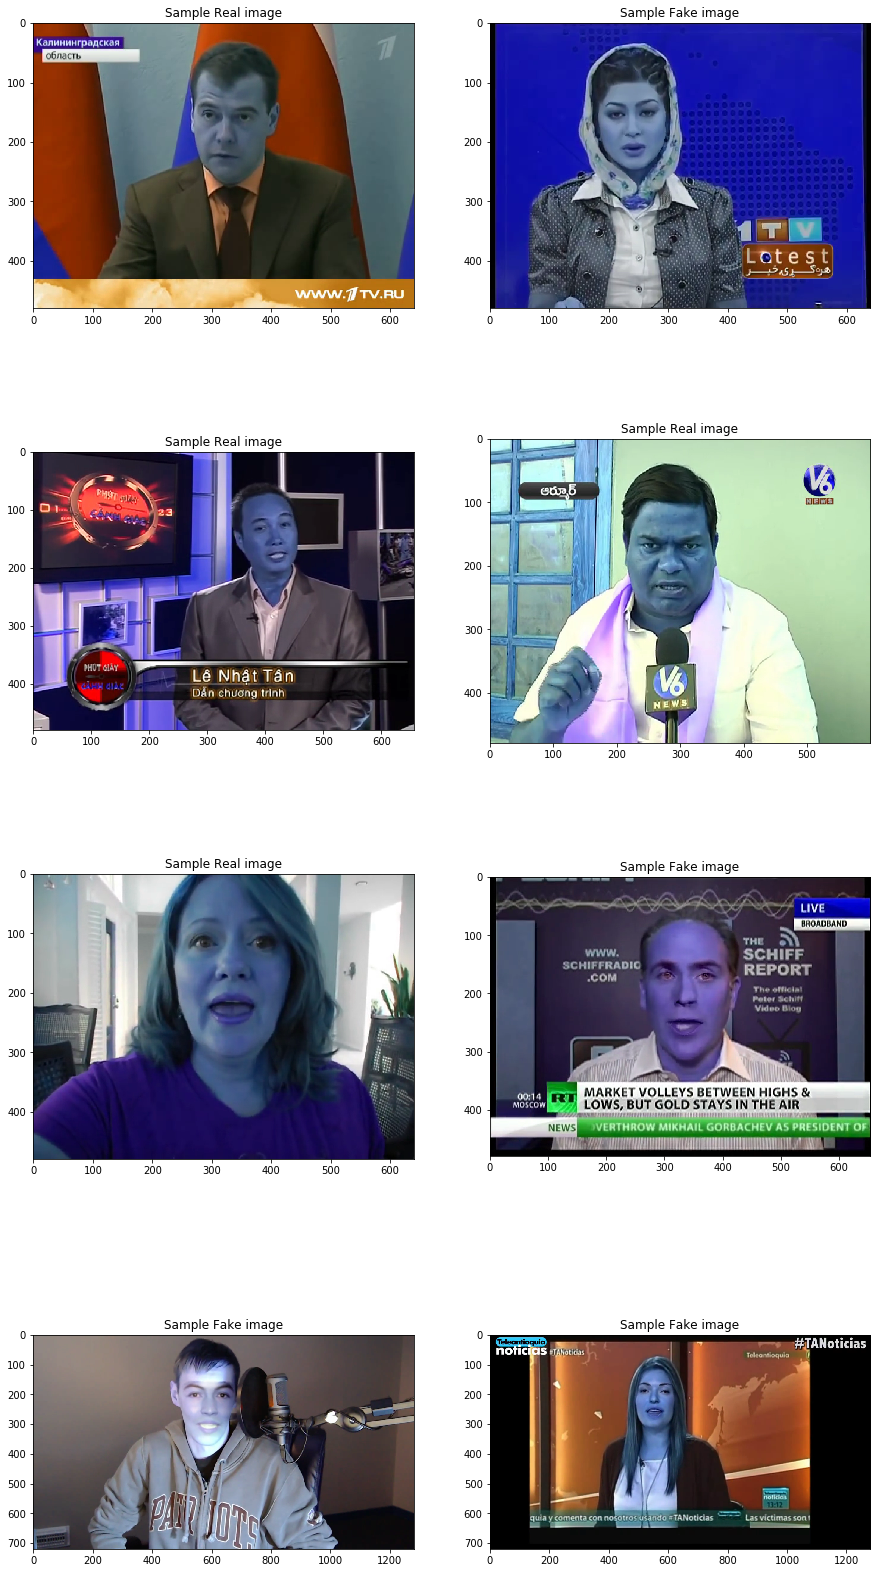

In [55]:
# generate random integer values
from random import seed
from random import randint
# seed random number generator
seed(12)

plt.figure(figsize=(15,30))
for i in range(8):
    random_value = randint(0,len(filenames_list)-1)
    sample_image = cv2.imread(os.path.join(dest_path,filenames_list[random_value]))
    plt.subplot(421+i)
    plt.title("Sample {} image".format("Fake" if labels[random_value] == 0 else "Real"))
    plt.imshow(sample_image)

### Lets do some data processing on the images before we feed them for training our model.
#### We need only to detect if the face has been manipulated, so we need to concentrate on the face portion of the image.

In [56]:
## Reference : https://github.com/ondyari/FaceForensics/blob/master/classification/detect_from_video.py
def get_boundingbox(face, width, height, scale=1.3, minsize=None):
    """
    Expects a dlib face to generate a quadratic bounding box.
    :param face: dlib face class
    :param width: frame width
    :param height: frame height
    :param scale: bounding box size multiplier to get a bigger face region
    :param minsize: set minimum bounding box size
    :return: x, y, bounding_box_size in opencv form
    """
    x1 = face.left()
    y1 = face.top()
    x2 = face.right()
    y2 = face.bottom()
    size_bb = int(max(x2 - x1, y2 - y1) * scale)
    if minsize:
        if size_bb < minsize:
            size_bb = minsize
    center_x, center_y = (x1 + x2) // 2, (y1 + y2) // 2

    # Check for out of bounds, x-y top left corner
    x1 = max(int(center_x - size_bb // 2), 0)
    y1 = max(int(center_y - size_bb // 2), 0)
    # Check for too big bb size for given x, y
    size_bb = min(width - x1, size_bb)
    size_bb = min(height - y1, size_bb)

    return x1, y1, size_bb

In [ ]:
## This method is used to take all the images and crop it and resize it for
## feeding it to the Keras Xception model.
def prepare_image(dataset_path):
    """
    This method will detect the face part of the image. Then face part will be cropped.
    The cropped image will be resized to 299x299 for the Keras Xception model. 
    :param dataset_path: path to the dataset
    :return: X, y
    """    
    data = []
    label_ind = 0
    for img in tqdm(os.listdir(dataset_path)):           
        try:
            image = cv2.imread(os.path.join(dataset_path,img))
            image =cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            faces = face_detector(image, 1)
            height, width = image.shape[:2]
            try: # If in case face is not detected at any frame 
                x, y, size = get_boundingbox(face=faces[0], width=width, height=height)
            except IndexError:
                print("No face found")
                continue
            # extract the image from the return coordinates of 'get_boundingbox' method
            img_array = image[y:y+size, x:x+size]
            # resize the image as we are using the Keras Xception model,the default input size for this model is 299x299. 
            new_array = cv2.resize(img_array, (299, 299))
            data.append([new_array, labels[label_ind]])
            label_ind = label_ind + 1
        except Exception as e:
            print(str(e))

    print("Split the data")
    X = []
    y = []
    for row in tqdm(data):
        X.append(row[0])
        y.append(row[1])
    X = np.array(X).reshape(-1, 299, 299, 3)
    y = to_categorical(y)
    return X,y

X, y = prepare_image("data_set")

In [ ]:
print(np.shape(X))
print(np.shape(y))


In [ ]:
from sklearn.model_selection import train_test_split


X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)
X_train, X_cv, Y_train, Y_cv = train_test_split(X_train, Y_train, test_size=0.33, random_state=42)

X_train = preprocess_input(X_train)
X_cv = preprocess_input(X_cv)
X_test = preprocess_input(X_test)

joblib.dump(X_train, 'x_train.pkl')
joblib.dump(X_test, 'x_test.pkl')
joblib.dump(Y_test, 'y_test.pkl')
joblib.dump(Y_train, 'y_train.pkl')
joblib.dump(X_cv, 'x_cv.pkl')
joblib.dump(Y_cv, 'y_cv.pkl')

In [ ]:
#Loading already preprocessed files.
x_train=joblib.load('x_train.pkl')
y_train=joblib.load('y_train.pkl')

x_test=joblib.load('x_test.pkl')
y_test=joblib.load('y_test.pkl')

x_cv=joblib.load('x_cv.pkl')
y_cv=joblib.load('y_cv.pkl')


In [ ]:
print(np.shape(y_train))
print(np.sum(y_train))

print(np.shape(y_test))
print(np.sum(y_test))

print(np.shape(y_cv))
print(np.sum(y_cv))

In [ ]:
## Lets view few cropped and processed images.

plt.figure(figsize=(15,30))
for i in range(8):
    random_value = randint(0,len(x_train)-1)    
    plt.subplot(421+i)    
    plt.title("Sample {} image".format("Fake" if np.argmax(y_train[random_value]) == 0 else "Real"))
    plt.imshow(x_train[random_value])

In [ ]:


Xception_model=Xception(include_top=False, weights='imagenet',input_shape=(299,299,3),pooling ='avg')
 

for layer in Xception_model.layers:
    layer.trainable = True

out_ = Xception_model.output
predicted = Dense(2,activation ='softmax')(out_)
model_face_forensic = Model(inputs= Xception_model.input, outputs = predicted)
model_face_forensic.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])

checkpoint = ModelCheckpoint('model_face_forensic.h5', monitor='val_loss', save_best_only=True)
tensorboard=TensorBoard(log_dir='./logs', update_freq='epoch')

history_face_forensic = model_face_forensic.fit(x_train, np.array(y_train),validation_data=(x_cv, np.array(y_cv)),
                                              callbacks=[checkpoint,tensorboard], batch_size = 32, verbose=2, epochs=12)


In [ ]:
#lets plot the train and val curve
#get the details form the history object
acc = history_face_forensic.history['accuracy']
val_acc = history_face_forensic.history['val_accuracy']
loss = history_face_forensic.history['loss']
val_loss = history_face_forensic.history['val_loss']

epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

In [ ]:
model_face_forensic.save("model_face_forensics.hdf5")

In [ ]:

# evaluate the model
scores = model_face_forensic.evaluate(x_test,np.array(y_test),verbose=0)
print("%s: %.2f%%" % (model_face_forensic.metrics_names[1], scores[1]*100))
 


In [ ]:
import cv2
from PIL import Image as pil_image
from tensorflow.keras.models import load_model

from tqdm import tqdm

def test_full_image_network(video_path,num_of_frames):    
    """
    Reads a video and evaluates a subset of frames using the network.
    Outputs are only given if a face is present and the face is highlighted using dlib.

    :param video_path: path to video file
    :param num_of_frames: number of frames to predict
    :return:
    """    
    
    print('Starting: {}'.format(video_path))
    
    # Read and write
    reader = cv2.VideoCapture(video_path)
    
    output_file_name = video_path.split("/")[-1].split(".")[-2] +'.avi'     

    fourcc = cv2.VideoWriter_fourcc(*'MJPG')
    fps = reader.get(cv2.CAP_PROP_FPS)
 
    writer = None
    if reader.isOpened():
        _, image = reader.read()
        
        # Image size
        height, width = image.shape[:2]

        # Init output writer
        if writer is None:
            writer = cv2.VideoWriter(output_file_name, fourcc, fps, (height, width)[::-1])
    else:
         _ = False
    
    i=1   
    # load model
    model = load_model('model_face_forensics.hdf5')
    while (_):
        
        _, image = reader.read()
        height, width = image.shape[:2]

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        faces = face_detector(image, 1)   
        face=faces[0]
        x, y, size = get_boundingbox(face=face, width=width, height=height)

        cropped_image = image[y:y+size, x:x+size]
        cropped_image = cv2.resize(cropped_image, (299, 299))
        cropped_image = np.expand_dims(cropped_image, axis=0)
        cropped_image = preprocess_input(cropped_image) 
        prediction = model.predict(cropped_image)[0]
        print("prediction::",prediction)
        if np.argmax(prediction)==0:
            label = 'Fake'
        else:
            label = 'Real'
        prediction_val = prediction[np.argmax(prediction)]*100.0

        font_face = cv2.FONT_HERSHEY_SIMPLEX # font settings
        thickness = 2
        font_scale = 1
        if label=='Real':
            color = (0,255, 0)
        else:
            color = (0, 0, 255)
        x = face.left()    # Setting the bounding box on uncropped image
        y = face.top()
        w = face.right() - x
        h = face.bottom() - y
        cv2.putText(image, label+'_'+str('%.2f'%prediction_val)+'%', (x, y+h+30),font_face, font_scale, color, thickness, 2) # Putting the label and confidence values        

        image_rect = cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)# draw box over face
        writer.write(image_rect)
        if i==num_of_frames:
            break
        i=i+1
    
    if writer is not None:
        writer.release()
        print('Finished! Output saved as {}'.format(output_file_name))
    else:
        print('Input video file was empty')
       
    return output_file_name   
  
    
     
    

In [ ]:

#For testing any new video
output_file_name = test_full_image_network(video_path='112.mp4', num_of_frames=10)



In [ ]:
from IPython.display import HTML

HTML('<iframe width="560" height="315" src="{0}" frameborder="0" allowfullscreen></iframe>'.format(output_file_name))
